<center><h1 style="font-size:40px;">Regression</h1></center>

Welcome to the third lab in the Deep learning course! In this lab we will continue to take a look at four parts for MLP regression;
* Introduction for setup and train an MLP
* Model selection for classification
* Impact of overfitting in validation performance 
* Avoid overfitting for a regression problem

The lab includes different datasets, both synthetic and real for regression task. 
The first part of the lab uses two different synthetic regression problems. The **regr1()** synthetic dataset is a two-dimensional dataset with linear and non-linear relationships between the input features and the output value. It is a good benchmark dataset for regression models, as it is challenging and realistic. The **generate_piecewise_linear_data()** function generates a synthetic dataset with piecewise linear relationships between the input features and the output value with varying amount of noise for each piece. 

All **Tasks** include **TODO's** these are expected to be done before the deadline for this lab. The **Tasks** also include question(s), which should be answered and included in the report. Some sections do not contain any **TODO's** but are good to understand.

Good luck!

---

## Intro to regression


The regression task is to learn a function f that maps from a set of input features X to a continuous output value y. The input features X can be either real-valued or categorical. The output value y is a real-valued number.

$$
y = f(X) + \epsilon
$$

The regression model is trained on a set of training data points, where the input features and the output values are known. The model learns to identify the relationship between the input features and the output values, and then uses this relationship to predict the output value for new input features.



## Necessary Imports 

In [31]:
# select gpu by index in case of multiple gpus
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import copy
from sklearn.model_selection import train_test_split
from sklearn import datasets
from torch.nn import MSELoss

## Let's use GPU if possible

In [33]:
# set device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## Dataset generator

In [34]:
class MLPData:
    """
    This class will manage all the dataset related functions for this lab.
    Please take the time do go through the code and try to understand how each point is generated
    """

    @staticmethod
    def regr1(N, v=0):
        """data(samples, features)

        :param N: param v:  (Default value = 0)
        :param v: Default value = 0)

        """
        data = np.empty(shape=(N, 2), dtype=np.float64)

        uni = lambda n: np.random.uniform(0, 1, n)
        norm = lambda n: np.random.normal(0, 1, n)
        noise = lambda n: np.random.normal(0, 1, (n,))
        data[:, 0] = norm(N)
        data[:, 1] = uni(N)

        tar = 10 * data[:, 0] + np.sin(20 * np.pi * data[:, 1])
        std_signal = np.std(tar)
        no = noise(N)
        tar = tar + v * std_signal * no
        return data, tar

    @staticmethod
    def generate_piecewise_linear_data(n_samples, n_segments, stocastic_noise=False):
        """
        Generates a piecewise linear dataset with n_segments segments.
        :param n_samples: Number of samples to generate
        :param n_segments: Number of segments to use
        :return: x, y

        """
        x = torch.rand(n_samples) * 10  # Generate random input values between 0 and 10
        y = torch.zeros(n_samples)

        segment_length = 10 / n_segments
        for i in range(n_segments):
            mask = (x >= i * segment_length) & (x < (i + 1) * segment_length)
            slope = torch.randn(1) * 2  # Random slope for each segment
            if stocastic_noise:
                noise = torch.randn(sum(mask)) * (0.5 + i * torch.randn(1))
            else:
                noise = torch.randn(sum(mask)) * (
                    0.5 + i * 0.2
                )  # Heteroscedastic noise
            y[mask] = slope * x[mask] + noise

        return x, y

Do not forget to instanciate an object of the above class for you to be able to generate dataset on the fly!

In [35]:
synthetic_datasets = MLPData()

Let's see how each dataset looks like! 

In [36]:
def data_distribution(imgs, shape=(2, 2)):
    """Plot scatter distribution for a list of images."""
    f, axs = plt.subplots(*shape, figsize=(10, 10))
    axs = axs.flatten()

    if isinstance(imgs, list):
        for idx, ((d, t), ax) in enumerate(zip(imgs, axs)):
            ax.scatter(d[:, 0], d[:, 1], c=t)
            ax.set_title(f"Plot number: {idx}")
    elif isinstance(imgs, dict):
        for (key, (d, t)), ax in zip(imgs.items(), axs):
            ax.scatter(d[:, 0], d[:, 1], c=t)
            ax.set_title(key)
    plt.show()

In [37]:
## Plotting synthetic datasets
# make sure you understand how the data is generated

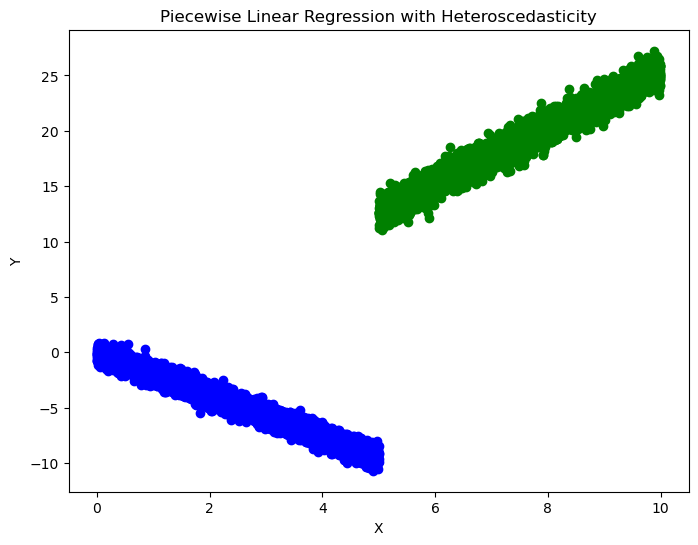

In [38]:
# Generate the synthetic dataset
n_samples = 10000
n_segments = 2
x, y = synthetic_datasets.generate_piecewise_linear_data(
    n_samples, n_segments, stocastic_noise=False
)

# Define colors for each segment
segment_colors = [
    "b",
    "g",
    "r",
    "c",
    "m",
] * (
    n_segments // 5 + 1
)  # Repeat the colors to have enough colors for each segment (up to 5 segments

# Plot the synthetic data with different colors for each segment
plt.figure(figsize=(8, 6))
for i in range(n_segments):
    mask = (x >= i * (10 / n_segments)) & (x < (i + 1) * (10 / n_segments))
    plt.scatter(x[mask], y[mask], label=f"Segment {i+1}", c=segment_colors[i])

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Piecewise Linear Regression with Heteroscedasticity")
plt.show()

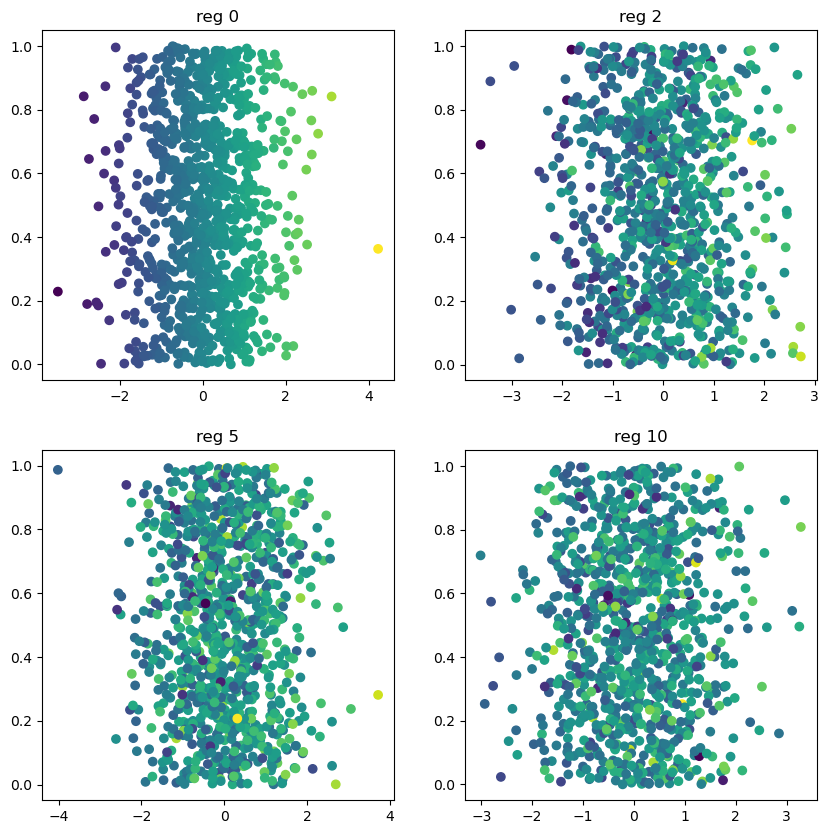

In [39]:
data_distribution(
    {
        "reg 0": MLPData.regr1(1000, v=0),
        "reg 2": MLPData.regr1(1000, v=2),
        "reg 5": MLPData.regr1(1000, v=5),
        "reg 10": MLPData.regr1(1000, v=10),
    },
    shape=(2, 2),
)

## Task 1

**Model definition**

In this lab exercise, you will design a Multi-Layer Perceptron (MLP) for regression. The goal is to create a simple neural network architecture to predict a continuous target variable based on input features. By completing this exercise, you will gain hands-on experience in configuring the architecture of an MLP for regression tasks.

    Task Description:

- Create an MLP architecture for regression.
- Define the input layer, hidden layers, and output layer.
- Configure the input layer to accept input data with dimensions specified as in_dimension.
- Design the hidden layers with num_hidden_layers layers and hidden_nodes neurons in each layer.
- Choose an appropriate activation function, specified as act, for the hidden layers. You can use common activation functions like ReLU (torch.nn.ReLU) for this purpose.
- Configure the output layer to have a linear activation function since this is a regression task.
- Define the output dimension to match your regression problem's requirements (specified as out_dimension).

In [40]:
class NeuralNet(torch.nn.Module):
    def __init__(self, in_dimension=2, hidden_nodes=100, num_hidden_layers=1, act=torch.nn.ReLU(), out_dimension=1):
        super(NeuralNet, self).__init__()
        self.layers = torch.nn.ModuleList()
        current_dim = in_dimension

        for _ in range(num_hidden_layers):
            self.layers.append(torch.nn.Linear(current_dim, hidden_nodes))
            self.layers.append(act)
            current_dim = hidden_nodes

        self.layers.append(torch.nn.Linear(hidden_nodes, out_dimension))
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)  # Move the model to the specified device

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x.squeeze(-1)

## Process the data for training

We need to make tensor from the numpy data generated from ```MLPData``` class and use them to create a PyTorch dataset. For this exercise we will use ```TensorDataset```. To iterate over the dataset, we need a data loader. We will use the default ```DataLoader```. You can find the corresponding documentation [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) and [here](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)

In [41]:
# let's start with 100 points
x, y = synthetic_datasets.regr1(10000)
# simply convert each array to a Tensor
x = torch.Tensor(x)
y = torch.Tensor(y.squeeze())
# create the TensorDataset
syn2_Pytorch = TensorDataset(x, y)
# create the dataloader.
loader = DataLoader(syn2_Pytorch, batch_size=1024)

# Task 2

Finish the below function. The task at this point is to create a function that is able to train your ```model``` for ```epoch_number``` using ```optimizer```, ```loss``` and ```dataloader```. You can read about optimizer [here](https://pytorch.org/docs/stable/optim.html)

In [42]:
def train_epoch(epoch, optimizer, loss, model, train_loader):
    model.train()  
    total_loss = 0

    for batch_idx, (xi, yi) in enumerate(train_loader):
        xi, yi = xi.to(model.device), yi.to(model.device)

        optimizer.zero_grad() 
        output = model(xi)     
        output = output.squeeze() 
        loss_fn = loss(output, yi)  
        loss_fn.backward()       
        optimizer.step()       

        total_loss += loss_fn.item() * xi.size(0)  

    average_loss = total_loss / len(train_loader.dataset)  
    return average_loss


Now that we have a way to trian our model, we need to create an instance of the model and train it. We still need a way to evaluate our model. In this simple datasets, we can try to visualize the decision boundaries. 

We will create one ```helper function```: ```plot_decision_boundary```

In [43]:
def plot_decision_boundary(dataset, y, model, steps=50):
    xmin, xmax = dataset[:, 0].min(), dataset[:, 0].max()
    ymin, ymax = dataset[:, 1].min(), dataset[:, 1].max()
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx_pred, yy_pred = np.meshgrid(x_span, y_span)
    model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

    model.eval()
    labels_predicted = model(Variable(torch.Tensor(model_viz)).float())

    labels_predicted = labels_predicted.detach().numpy()

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(dataset[:, 0], dataset[:, 1], y)
    ax.scatter(
        xx_pred.flatten(),
        yy_pred.flatten(),
        labels_predicted,
        facecolor=(0, 0, 0, 0),
        s=20,
        edgecolor="#70b3f0",
    )
    ax.view_init(elev=28, azim=120)
    plt.show()
    model.train()
    return fig, ax



In [44]:
def stats_reg(x, y, model):
    """
    Returns the MSE and CorrCoef for a given dataset and y
    """

    A = ["MSE", "CorrCoeff"]
    model.eval()
    preds = model(x)
    pcorr = np.corrcoef(y.flatten(), preds.detach().numpy().flatten())
    mse = torch.nn.MSELoss()(preds, y)

    B = [mse.item(), pcorr]

    print(f"\n {'#'*20} STATISTICS{'#'*20}\n")
    for r in zip(A, B):
        print(*r, sep="   ")
    return print(f"\n {'#'*50}")

## Task 3 

### Instantiation
Now the only thing missing to visualize you results is a trained network. **TODO:** Instantiate your model, loss and optimizer below. The choice of loss is critical for the training.  

In [45]:
# Instantiate the model
my_model = NeuralNet(in_dimension=2, hidden_nodes=100, num_hidden_layers=2, act=torch.nn.ReLU(), out_dimension=1)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model.to(device)

# Instantiate the loss function
criterion = torch.nn.MSELoss()

# Instantiate the optimizer
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.00195)


### Train the model

Now, our model, loss and optimizer are setup and we are ready to go Training

In [46]:
num_epoch = 100
train_losses = list()
for epoch in range(1, num_epoch + 1):
    epoch_loss = train_epoch(epoch, optimizer, criterion, my_model, loader)
    train_losses.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epoch}: Loss = {epoch_loss}")


Epoch 10/100: Loss = 0.5444846922874451
Epoch 20/100: Loss = 0.4946661452293396
Epoch 30/100: Loss = 0.4917354613304138
Epoch 40/100: Loss = 0.4906555848121643
Epoch 50/100: Loss = 0.4906015381813049
Epoch 60/100: Loss = 0.4911715647697449
Epoch 70/100: Loss = 0.4918230583190918
Epoch 80/100: Loss = 0.4924566384315491
Epoch 90/100: Loss = 0.49297178020477295
Epoch 100/100: Loss = 0.49294538831710816


In [47]:
def plot_decision_boundary(dataset, y, model, steps=50):
    xmin, xmax = dataset[:, 0].min(), dataset[:, 0].max()
    ymin, ymax = dataset[:, 1].min(), dataset[:, 1].max()
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx_pred, yy_pred = np.meshgrid(x_span, y_span)
   
    model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
    model_viz_tensor = torch.Tensor(model_viz).float().to(model.device)
    model.eval()

    labels_predicted = model(model_viz_tensor)
    labels_predicted = labels_predicted.detach().cpu().numpy()

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(dataset[:, 0], dataset[:, 1], y)
    ax.scatter(
        xx_pred.flatten(),
        yy_pred.flatten(),
        labels_predicted,
        facecolor=(0, 0, 0, 0),
        s=20,
        edgecolor="#70b3f0",
    )
    ax.view_init(elev=28, azim=120)
    plt.show()
    model.train()
    return fig, ax


In [48]:
def stats_reg(x, y, model):
    """
    Returns the MSE and CorrCoef for a given dataset and y
    """
    A = ["MSE", "CorrCoeff"]
    model.eval()

    x_device = x.to(model.device)
    y_device = y.to(model.device)

    preds = model(x_device)
    pcorr = np.corrcoef(y_device.cpu().flatten(), preds.detach().cpu().numpy().flatten())
    mse = torch.nn.MSELoss()(preds, y_device)

    B = [mse.item(), pcorr[0, 1]]  
    print(f"\n {'#'*20} STATISTICS{'#'*20}\n")
    for r in zip(A, B):
        print(*r, sep="   ")
    return print(f"\n {'#'*50}")


## Visualize the train losses 

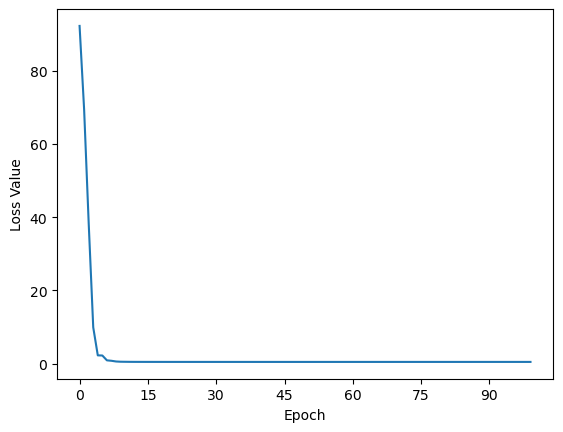

In [49]:
ax = plt.figure().gca()
plt.plot(np.arange(len(train_losses)), train_losses)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.show()

## Model Selection 

A proper training procedure is divided into ```3 splits```: training, validation and test. Generally, for each epoch, training is done on training data, and then a validation is done on the validation data. During validation the model weights are not updated. Best performing model on the validaiton data is selected and saved for final evaluation on test data. 

## Task 4

**TODO:** Split the data to 3 parts, one for training, one for validation and one hold out set for testing. A good starting point can be 70%, 15% and 15% of the dataset respectively for each split

**HINT** you can either do this manually with indexing or use readily available tools e.g. in sklearn

In [50]:
x, y = synthetic_datasets.regr1(10000)

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

x_train, x_valid, y_train, y_valid = train_test_split(x_train_val, y_train_val, test_size=(0.15/0.85), random_state=42)

x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train).squeeze()
x_valid_tensor = torch.Tensor(x_valid)
y_valid_tensor = torch.Tensor(y_valid).squeeze()
x_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.Tensor(y_test).squeeze()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024)
test_loader = DataLoader(test_dataset, batch_size=1024)


## Task 5
**TODO:** Complete the following functions. Run a proper training on each of the synthetic datasets you have created. Discuss the performance of model in report. What could be the reason behind the performance? Feel free to adapt the number of hidden nodes (and possibly the number of hidden layers and epochs)

In [51]:
def validate_epoch(epoch, loss, model, val_loader):
    model.eval() 
    total_loss = 0
    num_samples = 0
    
    with torch.no_grad():  
        for batch_idx, (xi, yi) in enumerate(val_loader):
            xi, yi = xi.to(model.device), yi.to(model.device) 
            output = model(xi)
            output = output.squeeze()  
            loss_value = loss(output, yi)  
            total_loss += loss_value.item() * xi.size(0)
            num_samples += xi.size(0)

    average_loss = total_loss / num_samples
    return average_loss


In [52]:
def a_proper_training(num_epoch, model, optimizer, loss, train_loader, val_loader):
    best_val_loss = float('inf')
    best_model = copy.deepcopy(model.state_dict()) 
    train_losses = []
    val_losses = []
    
    for epoch in range(1, num_epoch + 1):
        train_loss = train_epoch(epoch, optimizer, loss, model, train_loader)
        val_loss = validate_epoch(epoch, loss, model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())  
        
        if epoch % 10 == 0 or epoch == 1:
            print(f'Epoch {epoch}/{num_epoch} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    model.load_state_dict(best_model)
    return model, train_losses, val_losses

In [53]:
my_model = NeuralNet(in_dimension=2, hidden_nodes=100, num_hidden_layers=2, act=torch.nn.ReLU(), out_dimension=1)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model.to(device)
    
# Instantiate the loss function 
criterion = torch.nn.MSELoss()

# Instantiate the optimizer 
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.003)

Epoch 1/100 - Training Loss: 90.5335, Validation Loss: 73.9705
Epoch 10/100 - Training Loss: 0.6941, Validation Loss: 0.5596
Epoch 20/100 - Training Loss: 0.5092, Validation Loss: 0.5026
Epoch 30/100 - Training Loss: 0.5054, Validation Loss: 0.5004
Epoch 40/100 - Training Loss: 0.5025, Validation Loss: 0.4981
Epoch 50/100 - Training Loss: 0.5012, Validation Loss: 0.4989
Epoch 60/100 - Training Loss: 0.5002, Validation Loss: 0.4971
Epoch 70/100 - Training Loss: 0.5007, Validation Loss: 0.4962
Epoch 80/100 - Training Loss: 0.5016, Validation Loss: 0.4982
Epoch 90/100 - Training Loss: 0.4987, Validation Loss: 0.4974
Epoch 100/100 - Training Loss: 0.4960, Validation Loss: 0.4936


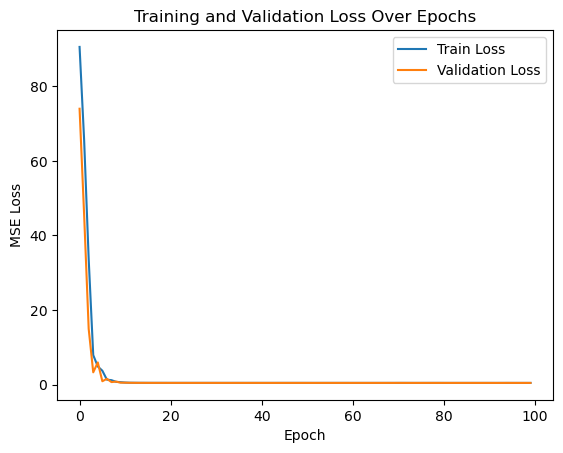

In [54]:
num_epochs = 100  
best_model, train_losses, val_losses = a_proper_training(num_epochs, my_model, optimizer, criterion, train_loader, valid_loader)

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

## Task 6 

Add dropout to the model, and rerun the previous experiment, does it have any effect and why?

In [55]:
class NeuralNet(torch.nn.Module):
    def __init__(
        self,
        in_dimension=2,
        hidden_nodes=100,
        num_hidden_layers=2,
        act=torch.nn.ReLU(inplace=True),
        out_dimension=1,
        dropout_probability=0.5 
    ):
        super(NeuralNet, self).__init__()
        layers = [torch.nn.Linear(in_dimension, hidden_nodes), act, torch.nn.Dropout(p=dropout_probability)]
        
        for _ in range(num_hidden_layers - 1):
            layers += [torch.nn.Linear(hidden_nodes, hidden_nodes), act, torch.nn.Dropout(p=dropout_probability)]
        
        layers.append(torch.nn.Linear(hidden_nodes, out_dimension))
        
        self.layers = torch.nn.Sequential(*layers)
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)  
        
    def forward(self, x):
        return self.layers(x)
    
    def predict(self, x):
        return self.forward(x)


In [56]:
my_model = NeuralNet(in_dimension=2, hidden_nodes=100, num_hidden_layers=2, act=torch.nn.ReLU(), out_dimension=1)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model.to(device)
    
# Instantiate the loss function 
criterion = torch.nn.MSELoss()

# Instantiate the optimizer 
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.003)

Epoch 1/100 - Training Loss: 90.0409, Validation Loss: 71.2487
Epoch 10/100 - Training Loss: 6.8568, Validation Loss: 1.1133
Epoch 20/100 - Training Loss: 5.3629, Validation Loss: 0.7527
Epoch 30/100 - Training Loss: 4.8710, Validation Loss: 0.6926
Epoch 40/100 - Training Loss: 4.9155, Validation Loss: 0.6938
Epoch 50/100 - Training Loss: 4.6384, Validation Loss: 0.5847
Epoch 60/100 - Training Loss: 4.5754, Validation Loss: 0.6425
Epoch 70/100 - Training Loss: 4.3893, Validation Loss: 0.7558
Epoch 80/100 - Training Loss: 4.3495, Validation Loss: 0.5877
Epoch 90/100 - Training Loss: 4.1665, Validation Loss: 0.7200
Epoch 100/100 - Training Loss: 4.3387, Validation Loss: 0.6561


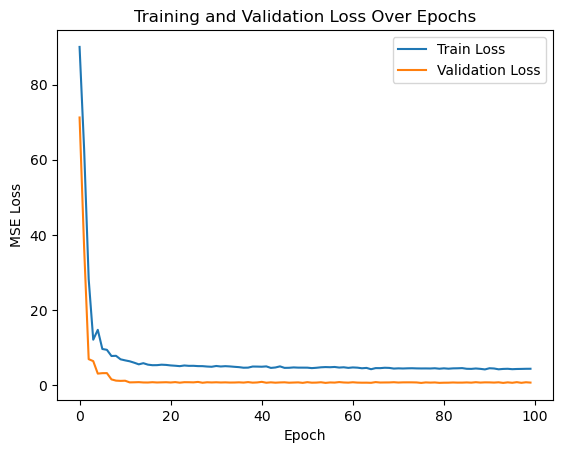

In [57]:
num_epochs = 100  
best_model, train_losses, val_losses = a_proper_training(num_epochs, my_model, optimizer, criterion, train_loader, valid_loader)

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

- The first thing I notice, The training loss is higher with dropout compared to without dropout, which is expected because dropout randomly drops units during training, making the training process noisier and typically slower.

- The final validation loss did not improve as much compared to the model without dropout, which might indicate that either the dropout rate is too high or the model needs more epochs to train.

- There is more variability in the validation loss across epochs, which can be a sign that the model is learning more robust features due to the regularization effect of dropout.

WHY? because Dropout is a regularization technique designed to prevent overfitting which helps to make the model more robust as it cannot rely on any single feature too much.


## Task 7


**TODO!** Rerun the experiment with the second synthetic dataset, with splitting, and proper training. Feel free to play with the parameters of the models

In [58]:
n_samples = 10000
n_segments = 5
X, y = synthetic_datasets.generate_piecewise_linear_data(
    n_samples, n_segments, stocastic_noise=True
)

X_tensor = torch.Tensor(X).unsqueeze(1) 
y_tensor = torch.Tensor(y)  

X_train_val, X_test, y_train_val, y_test = train_test_split(X_tensor, y_tensor, test_size=0.15, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=(0.15/0.85), random_state=42)


train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024)
test_loader = DataLoader(test_dataset, batch_size=1024)

In [59]:
my_model = NeuralNet(in_dimension=1, hidden_nodes=14, num_hidden_layers=1, out_dimension=1)
my_model.to(device)  
criterion = MSELoss() 
optimizer = Adam(my_model.parameters(), lr=0.002)

In [60]:
best_model, train_losses, val_losses = a_proper_training(
    num_epoch=1000,  
    model=my_model,
    optimizer=optimizer,
    loss=criterion,  
    train_loader=train_loader,
    val_loader=valid_loader
)

Epoch 1/1000 - Training Loss: 101.0881, Validation Loss: 103.3323
Epoch 10/1000 - Training Loss: 67.8139, Validation Loss: 64.5978
Epoch 20/1000 - Training Loss: 57.9272, Validation Loss: 51.4946
Epoch 30/1000 - Training Loss: 55.3284, Validation Loss: 49.8441
Epoch 40/1000 - Training Loss: 54.4922, Validation Loss: 49.2603
Epoch 50/1000 - Training Loss: 54.8211, Validation Loss: 48.7438
Epoch 60/1000 - Training Loss: 55.3453, Validation Loss: 48.3553
Epoch 70/1000 - Training Loss: 53.5481, Validation Loss: 48.0352
Epoch 80/1000 - Training Loss: 53.2581, Validation Loss: 47.6293
Epoch 90/1000 - Training Loss: 52.6624, Validation Loss: 47.1392
Epoch 100/1000 - Training Loss: 51.8117, Validation Loss: 46.9254
Epoch 110/1000 - Training Loss: 51.4988, Validation Loss: 46.3365
Epoch 120/1000 - Training Loss: 51.5949, Validation Loss: 46.0398
Epoch 130/1000 - Training Loss: 50.6219, Validation Loss: 45.6548
Epoch 140/1000 - Training Loss: 50.9278, Validation Loss: 45.2217
Epoch 150/1000 - Tr

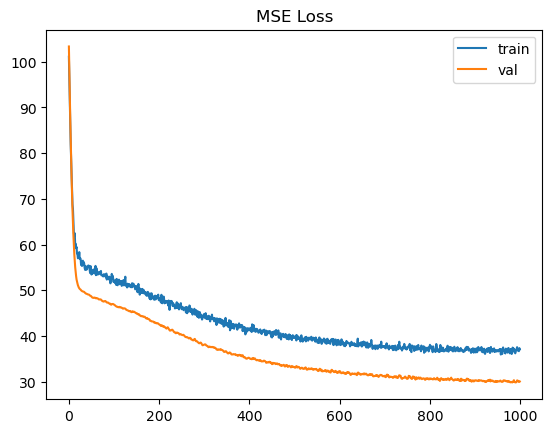

In [61]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("MSE Loss")
plt.legend()
plt.show()

In [62]:
def stats_reg(dataloader, model):
    """
    Returns the MSE and CorrCoef for a given PyTorch dataset and model
    """
    A = ["MSE", "CorrCoeff"]
    model.eval()
    total_mse = 0
    total_corr = []
    
    with torch.no_grad():
        for x, y in dataloader:
            preds = model(x.to(device))  
            preds = preds.squeeze() 
            total_mse += nn.MSELoss()(preds, y.to(device)).item() 
            total_corr.append(np.corrcoef(y.cpu().numpy().flatten(), preds.cpu().numpy().flatten())[0, 1])  

    B = [total_mse / len(dataloader), np.mean(total_corr)]
    
    print(f"\n {'#'*20} STATISTICS{'#'*20}\n")
    for r in zip(A, B):
        print(f"{r[0]}: {r[1]:.4f}")
    print(f"\n {'#'*50}")


In [63]:
stats_reg(test_loader, my_model)


 #################### STATISTICS####################

MSE: 30.4515
CorrCoeff: 0.7861

 ##################################################


<center><h1 style="font-size:40px;">Real dataset</h1></center>

## Task 9

In the following example, we will import the diabetes dataset. This dataset contains data from diabetic patients and contains certain features such as their bmi, age , blood pressure and glucose levels which are useful in predicting the diabetes disease progression in patients.

Here are the key details of the sklearn diabetes dataset:

- Target Variable: The target variable is a quantitative measure of disease progression, which represents the one-year change in a patient's disease progression. It is a continuous variable, not a binary classification of diabetes.
- Features (Predictors):
    The dataset contains ten baseline variables (predictors) that are used to predict the disease progression:

        - Age
        - Sex
        - BMI (Body Mass Index)
        - Average Blood Pressure
        - S1: Total serum cholesterol
        - S2: Low-density lipoproteins (LDL cholesterol)
        - S3: High-density lipoproteins (HDL cholesterol)
        - S4: Total cholesterol / HDL cholesterol ratio
        - S5: Log of serum triglycerides level
        - S6: Blood sugar level

In [64]:
diabetes = datasets.load_diabetes(scaled=True, as_frame=True, return_X_y=True)
X, y = diabetes[0], diabetes[1]

X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=(0.15/0.85), random_state=42)


In [65]:
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [66]:
my_model = NeuralNet(in_dimension=X.shape[1], hidden_nodes=100, num_hidden_layers=2, out_dimension=1)
my_model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)


In [67]:
best_model, train_losses, val_losses = a_proper_training(
    num_epoch=1000,  
    model=my_model,
    optimizer=optimizer,
    loss=criterion,
    train_loader=train_loader,
    val_loader=valid_loader
)


Epoch 1/1000 - Training Loss: 29326.8795, Validation Loss: 29693.5897
Epoch 10/1000 - Training Loss: 24748.2915, Validation Loss: 24364.0955
Epoch 20/1000 - Training Loss: 7433.4905, Validation Loss: 6205.6968
Epoch 30/1000 - Training Loss: 5252.5539, Validation Loss: 3990.5213
Epoch 40/1000 - Training Loss: 5212.4381, Validation Loss: 3593.5351
Epoch 50/1000 - Training Loss: 4272.2337, Validation Loss: 3282.6850
Epoch 60/1000 - Training Loss: 4354.9464, Validation Loss: 3067.2723
Epoch 70/1000 - Training Loss: 4188.8520, Validation Loss: 2910.8691
Epoch 80/1000 - Training Loss: 4220.2208, Validation Loss: 2793.7062
Epoch 90/1000 - Training Loss: 4269.1159, Validation Loss: 2706.7798
Epoch 100/1000 - Training Loss: 3930.9494, Validation Loss: 2632.6730
Epoch 110/1000 - Training Loss: 4024.8264, Validation Loss: 2580.4135
Epoch 120/1000 - Training Loss: 3808.0375, Validation Loss: 2537.9991
Epoch 130/1000 - Training Loss: 3771.9142, Validation Loss: 2504.3280
Epoch 140/1000 - Training L

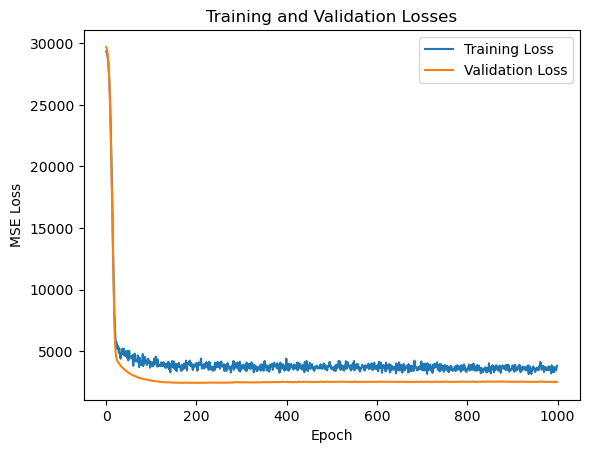


 #################### STATISTICS####################

MSE: 3273.5119
CorrCoeff: 0.5521

 ##################################################


In [68]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()

stats_reg(test_loader, best_model)


**TODO:**  run the experiments for the diabetes dataset, do you get similar performance? why? Do you suffer from overfitting/underfitting?


- Both models generalize well without obvious signs of overfitting.
- The second graph shows much higher loss values, which suggests that the model may not be performing as well quantitatively on the task it's trained for. 

- Overfitting is not observed in either of the graphs, which is a good sign.
- In both cases, the possibility of underfitting is suggested more than overfitting, given that the losses plateau and maintain a constant gap.

## Task 10

**TODO** try applying l1 and l2 regularization, does it help with the performance? Why?

**HINT** in pytorch l2 can be applied by adding weight decay to optimizer, and for adding L1, you can choose HuberLoss instead of MSE. Or feel free to apply them manually

Epoch 0: Train Loss = 477.1122, Validation Loss = 596.1874
Epoch 100: Train Loss = 51.5712, Validation Loss = 58.6540
Epoch 200: Train Loss = 47.6489, Validation Loss = 51.1514
Epoch 300: Train Loss = 46.8804, Validation Loss = 50.6327
Epoch 400: Train Loss = 46.9761, Validation Loss = 51.2988
Epoch 500: Train Loss = 46.0521, Validation Loss = 51.1263
Epoch 600: Train Loss = 45.4619, Validation Loss = 50.9935
Epoch 700: Train Loss = 45.6192, Validation Loss = 52.1404
Epoch 800: Train Loss = 44.8912, Validation Loss = 50.7958
Epoch 900: Train Loss = 44.4574, Validation Loss = 51.7482


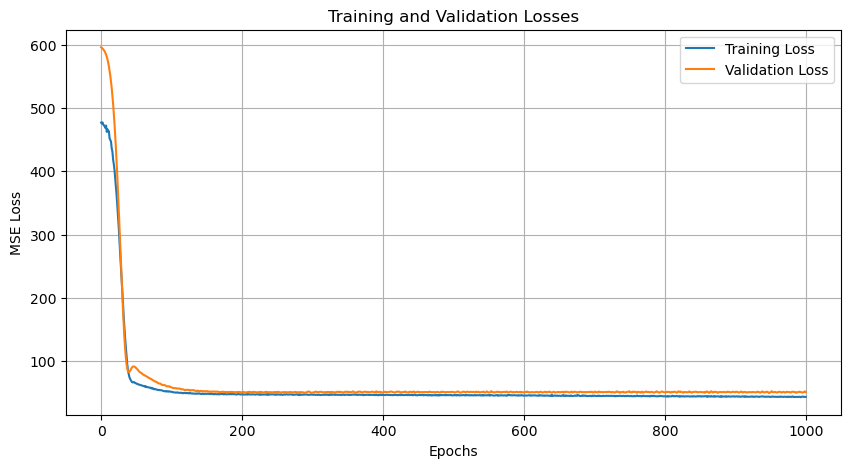

In [69]:
diabetes = datasets.load_diabetes(return_X_y=True)
X, y = diabetes

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1) 

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class NeuralNet(nn.Module):
    def __init__(self, in_dimension=10, hidden_nodes=100, num_hidden_layers=2, out_dimension=1):
        super(NeuralNet, self).__init__()
        self.layers = nn.ModuleList()
        current_dim = in_dimension

        for _ in range(num_hidden_layers):
            self.layers.append(nn.Linear(current_dim, hidden_nodes))
            self.layers.append(nn.ReLU())
            current_dim = hidden_nodes

        self.layers.append(nn.Linear(hidden_nodes, out_dimension))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x.squeeze(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet().to(device)


def l1_regularization(model, lambda_l1):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training function
def train_epoch(epoch, optimizer, loss_function, model, train_loader, lambda_l1, device):
    model.train()
    total_loss = 0
    for batch_idx, (xi, yi) in enumerate(train_loader):
        xi, yi = xi.to(device), yi.to(device).squeeze(-1) 

        optimizer.zero_grad()
        output = model(xi)
        mse_loss = loss_function(output, yi)
        l1_loss = l1_regularization(model, lambda_l1)
        loss = mse_loss + l1_loss  
        loss.backward()
        optimizer.step()

        total_loss += mse_loss.item()  

    average_loss = total_loss / len(train_loader.dataset)
    return average_loss

def validate_epoch(epoch, loss, model, val_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (xi, yi) in enumerate(val_loader):
            xi, yi = xi.to(device), yi.to(device).squeeze(-1)  
            output = model(xi)
            loss_fn = loss(output, yi)
            total_loss += loss_fn.item()

    average_loss = total_loss / len(val_loader.dataset)
    return average_loss


num_epochs = 1000
lambda_l1 = 1e-4  
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    train_loss = train_epoch(epoch, optimizer, criterion, model, train_loader, lambda_l1, device)
    val_loss = validate_epoch(epoch, criterion, model, valid_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")

model.load_state_dict(best_model)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


Yes, based on the second graph, regularization appears to have helped. The overall lower loss values after applying L1 and L2 regularization suggest an improved performance of the model.


WHY?
because applying L1 and L2 regularization reduces overfitting and leads to a model that generalizes better to the validation set.